<a href="https://www.kaggle.com/code/norikokono/palette-skills-capstone-1?scriptVersionId=241361641" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-hut-reviews/pizza-hut-reviews.csv
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/config.json
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/tokenizer.json
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/metadata.json
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/model.weights.h5
/kaggle/input/gemma/keras/gemma_instruct_2b_en/2/assets/tokenizer/vocabulary.spm


In [2]:
import nltk
import altair as alt
import string
import keras
import keras_hub
import keras_nlp
import re
import tensorflow as tf
import matplotlib.pyplot as plt

2025-05-23 06:53:53.313649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747983233.588418      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747983233.666288      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="background-color:#e4f7f5; padding:20px; border-radius:5px;">
    <h1>🍕👒 Sentiment Analysis on Pizza Hut Reviews Dataset</h1>
    <p>I am using one of Kaggle's public datasets, the <a href="https://www.kaggle.com/datasets/abhi10699/pizza-hut-reviews">Pizza Hut Reviews Dataset</a>.</p>
    <blockquote>
        This dataset captures customer sentiments regarding Pizza Hut’s food quality, service, and overall experience. The data was collected through web scraping and consists of user-generated reviews along with associated ratings and metadata. I found this via Google Dataset Search.
    </blockquote>
    <h2>Data Overview</h2>
    <h3>About Data</h3>
    <blockquote>
        Data represents customer sentiments regarding Pizza Hut food and other services.
        Data was collected by web scraping: <a href="https://www.consumeraffairs.com/food/pizza-hut.html">Pizza Hut Food Reviews</a>
    </blockquote>
    <h3>Data Columns</h3>
    <ul>
        <li><code>id</code></li>
        <li><code>customer_review</code></li>
        <li><code>review_submitted_on_date</code></li>
        <li><code>overall_ratings</code></li>
        <li><code>upvotes_number</code></li>
    </ul>
    <h3>Possible Applications</h3>
    <ul>
        <li>Sentiment Analysis</li>
        <li>Can figure out the trend of reviews based on time</li>
    </ul>
</div>

## 🔎 Exploratory Data Analysis (EDA)

<div style="background: linear-gradient(to right, #d9edf7, #bce8f1); 
            color: #31708f; 
            padding: 15px; 
            border-radius: 5px;">
    
  <h3>Loading the Data into the Data Frame</h3>

  <h3>Sentiment Analysis</h3>
  <ul>
    <li>The <code>customer_review</code> column will be analyzed to determine sentiment (Positive, Neutral, or Negative).</li>
    <li>Sentiment classification will be performed using NLP techniques like VADER or TextBlob.</li>
    <li>Insights can be drawn to understand customer satisfaction and trends over time.</li>
  </ul>

  <h3>Train-Test Split</h3>
  <ul>
    <li>The dataset will be divided into training and test sets for further analysis and model development.</li>
    <li>A typical split ratio is <strong>80% for training</strong> and <strong>20% for testing</strong>.</li>
    <li>The split ensures robust performance evaluation of sentiment analysis models.</li>
  </ul>
</div>

In [3]:
df = pd.read_csv("/kaggle/input/pizza-hut-reviews/pizza-hut-reviews.csv")
df.head()

,id,review,created_at,ratings,upvotes
0,1,The staff Alexa was very kind and helpful. I h...,"May 28, 2022",1,0
1,2,"I ordered 4 pizzas One veggie lover, one chees...","May 18, 2022",1,0
2,3,"My experience was bad. Had a long day, want to...","May 15, 2022",1,0
3,4,"I do not suggest you order from Pizza Hut, I l...","May 14, 2022",1,2
4,5,Pizza Hut is a scam! I never got my pizza deli...,"May 12, 2022",1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          605 non-null    int64 
 1   review      605 non-null    object
 2   created_at  605 non-null    object
 3   ratings     605 non-null    int64 
 4   upvotes     605 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 23.8+ KB


In [5]:
df.shape

(605, 5)

<div style="background: linear-gradient(to right, #d9edf7, #bce8f1); 
            color: #31708f; 
            padding: 15px; 
            border-radius: 5px; 
            border: 1px solid #bce8f1;
            display: inline-block;">
    <strong>Note:</strong> All columns have no missing values.
</div>

## 📊 VADER Sentiment Analysis
> VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media, and works well on texts from other domains.

📝 Memo: 
> nltk (Natural Language Toolkit) is a powerful Python library used for working with human language data. It provides tools for text processing, tokenization, part-of-speech tagging, and sentiment analysis, among other NLP tasks.

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment scores
def get_sentiment(text):
    scores = sia.polarity_scores(str(text))  # Convert to string in case of missing values
    if scores['compound'] >= 0.05:
        return "Positive"
    elif scores['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply function to classify sentiment
df["sentiment"] = df["review"].apply(get_sentiment)

# Show sample output
print(df[["review", "sentiment"]].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                              review sentiment
0  The staff Alexa was very kind and helpful. I h...  Positive
1  I ordered 4 pizzas One veggie lover, one chees...  Positive
2  My experience was bad. Had a long day, want to...  Negative
3  I do not suggest you order from Pizza Hut, I l...  Positive
4  Pizza Hut is a scam! I never got my pizza deli...  Negative


<section style="color: #333; background: linear-gradient(90deg, rgba(215,225,230,1) 0%, rgba(225,230,225,1) 50%, rgba(235,235,220,1) 100%); padding: 20px; font-size: 16px; border-radius: 8px; line-height: 1.5;">
  <p>
    It is obvious that this sentiment classifier is not 100% accurate. For example, a review starting with “I do not suggest you order from Pizza Hut, I l…” is simply labeled as “Positive,” which contradicts the customer's comment.
  </p>
  <p>
    According to the 
    <a href="https://hex.tech/templates/sentiment-analysis/vader-sentiment-analysis/#:~:text=This%20is%20it%2C%20you%20have,but%20it%20does%20the%20job." target="_blank" style="color: #333; text-decoration: underline;">
      How to Build: VADER Sentiment Analysis
    </a> guide, while VADER—a tool designed for capturing the sentiment of casual and informal language—achieves around 61% accuracy, that level of performance is often acceptable for many practical applications.
    <br><br>
    "This is it, you have now created a sentiment classifier with a few simple steps. VADER is a pretty handy tool for analyzing the sentiment of social media text as these platforms allow the use of casual and informal language. We were able to achieve around 61% accuracy which is not too good but it does the job."
  </p>
  <p>
    Given the inherent complexities and nuances of language that make sentiment analysis challenging for machines, I believe the achieved accuracy is reasonable; therefore, I will continue utilizing these results.
  </p>
</section>

In [7]:
from sklearn.model_selection import train_test_split, cross_validate

# Splitting dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=111)

# Features (X) and labels (y)
X_train = train_df["review"]
y_train = train_df["sentiment"]
X_test = test_df["review"]
y_test = test_df["sentiment"]

In [8]:
class_dist = train_df['sentiment'].value_counts()
class_dist

sentiment
Negative    270
Positive    200
Neutral      14
Name: count, dtype: int64

<p style="color: white; background: #2A7B9B; background: linear-gradient(90deg, rgba(42, 123, 155, 1) 0%, rgba(87, 199, 133, 1) 50%, rgba(237, 221, 83, 1) 100%);; padding: 10px; font-size: 16px;">
I didn’t expect this response even though personally, I have rarely ordered food from Pizza Hut,  Given that it’s such a popular restaurant chain, it's surprising that people are this upset about the food and service.
I want to identify the words people use to express their reviews.
</p>

In [9]:
from nltk.corpus import stopwords
from collections import Counter

# Download stopwords if necessary
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine all positive sentiment reviews into a single text string
positive_text = " ".join(df[df["sentiment"] == "Positive"]["review"].astype(str))

# Tokenize and clean the text (removing punctuation and converting to lowercase)
words = re.findall(r'\b\w+\b', positive_text.lower())

# Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Count word frequencies
word_counts = Counter(filtered_words)

# Get the most common words
most_common_words = word_counts.most_common(20)  # Adjust the number as needed

print(most_common_words)

[('pizza', 671), ('hut', 260), ('order', 221), ('ordered', 115), ('time', 101), ('like', 92), ('said', 91), ('called', 82), ('crust', 82), ('would', 79), ('cheese', 75), ('get', 74), ('store', 73), ('delivery', 71), ('food', 67), ('pizzas', 65), ('one', 64), ('service', 61), ('good', 61), ('never', 59)]


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Download stopwords if necessary
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Combine all positive sentiment reviews into a single text string
negative_text = " ".join(df[df["sentiment"] == "Negative"]["review"].astype(str))

# Tokenize and clean the text (removing punctuation and converting to lowercase)
words = re.findall(r'\b\w+\b', negative_text.lower())

# Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Count word frequencies
word_counts = Counter(filtered_words)

# Get the most common words
most_common_words = word_counts.most_common(20)  # Adjust the number as needed

print(most_common_words)

[('pizza', 723), ('order', 424), ('hut', 309), ('ordered', 169), ('called', 166), ('time', 143), ('told', 137), ('said', 135), ('back', 133), ('store', 129), ('would', 122), ('get', 116), ('one', 115), ('delivery', 114), ('got', 113), ('never', 110), ('2', 101), ('call', 100), ('manager', 99), ('service', 97)]


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


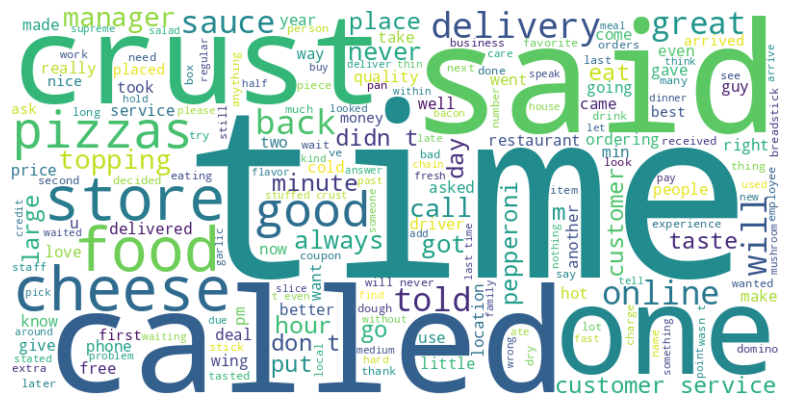

In [11]:
from wordcloud import WordCloud

# List of words to exclude
exclude_words = {"pizza", "order", "hut", "ordered", "s"}

# Tokenize and clean the text
words = re.findall(r'\b\w+\b', positive_text.lower())

# Remove unwanted words
filtered_words = [word for word in words if word not in exclude_words]

# Recreate the text after filtering
filtered_text = " ".join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(filtered_text)

# Display the word cloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

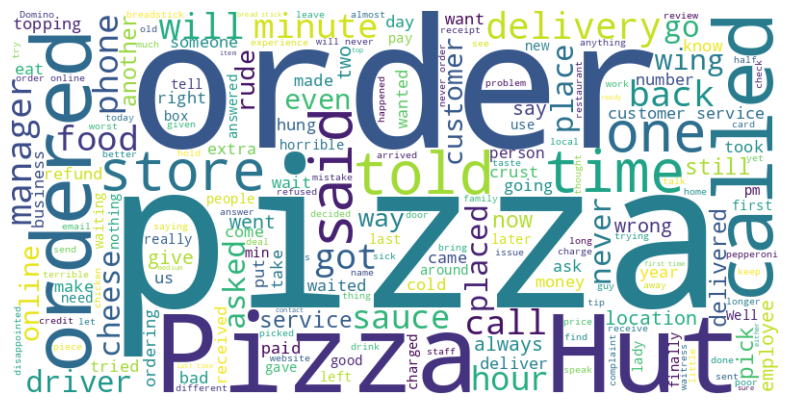

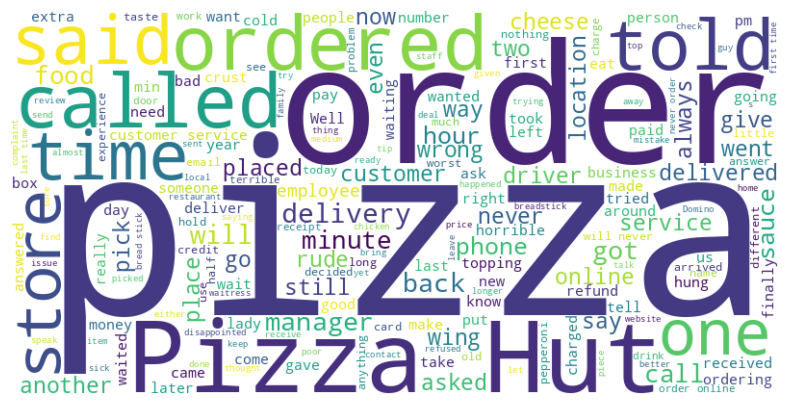

In [12]:
from wordcloud import WordCloud

# Filter only negative sentiment text entries
negative_text = " ".join(df[df["sentiment"] == "Negative"]["review"].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(negative_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
class_dist.isnull().sum()

0

In [14]:
review_length_df = train_df.copy()
review_length_df.loc[:, 'review_wordcount'] = review_length_df['review'].str.split().str.len()
review_length_df

,id,review,created_at,ratings,upvotes,sentiment,review_wordcount
433,434,My wife and I went to Pizza Hut in Pryor Oklah...,"Oct. 27, 2015",1,7,Negative,124
586,587,"I ordered delivery from 700 Maguire Blvd, Orla...","March 29, 2014",1,20,Positive,180
140,141,"It is so easy to make your own pizza, custom t...","Jan. 3, 2020",3,0,Positive,66
233,234,"I love the pizza; however, I have had several ...","Jan. 13, 2019",1,0,Negative,70
595,596,I was parked in the Pizza Hut parking lot. My ...,"July 20, 2012",1,5,Negative,109
...,...,...,...,...,...,...,...
7,8,"""Dear sir, Order number Your Order No ** has b...","April 14, 2022",1,3,Negative,102
118,119,I called to placed an order for carry out at t...,"Feb. 1, 2020",1,5,Negative,117
322,323,I called to place an order for delivery and sp...,"July 1, 2017",5,9,Positive,108
275,276,Pizza Hut took the container used to keep the ...,"April 17, 2018",2,5,Negative,40


📝 Memo
> This happens because every review in your column is unique. When you use value_counts(normalize=True), each unique review appears only once, so its normalized count is ( \frac{1}{\text{total number of reviews}} ). In your case, ( \frac{1}{605} \approx 0.001653 ), meaning your dataframe has roughly 605 unique reviews.

In [15]:
df['review'].value_counts(normalize = True)

review
The staff Alexa was very kind and helpful. I had donated 20 pizzas to my children's graduation party/dance. I went in person to make sure I placed such a large order correctly and was going to be delivered to the correct place at the proper time. I asked about getting my reward points for this extremely large order. The staff said “I’m sorry I can’t get a receipt right now”. However, I went back in a few days later she was able to print a receipt out for me and gave me a phone number to call customer service to ask that the points to be added. Customer service said the points weren’t added because they didn’t have my phone number or my name. I sent a copy of the receipt circle the top in red that has my name in phone number on it. That is how I place the order in the first place.     0.001653
Are you serious? You closed without delivering my pizza!!?? Never again.                                                                                                                     

In [16]:
# Calculate the average word count for negative sentiment reviews
neg_wc_avg = round(review_length_df[review_length_df["sentiment"] == "Negative"]["review_wordcount"].mean())

# Calculate the average word count for positive sentiment reviews
pos_wc_avg = round(review_length_df[review_length_df["sentiment"] == "Positive"]["review_wordcount"].mean())

# Print the results
print(neg_wc_avg)
print(pos_wc_avg)

97
92


In [17]:
# Grouping data by sentiment and calculating the average review word count
avg_wc = review_length_df.groupby('sentiment', as_index=False)['review_wordcount'].mean()

# Creating the bar chart with different colors for each sentiment
plot_avg_wc = alt.Chart(avg_wc).mark_bar().encode(
    x=alt.X('sentiment:N', title='Sentiment'),
    y=alt.Y('review_wordcount:Q', title='Average Review Word Count'),
    color=alt.Color('sentiment:N', scale=alt.Scale(scheme='category20')) # Assigning colors
).properties(
    title='The Average Review Word Count per Sentiment',
    width=400 
)

# Display the chart
plot_avg_wc

alt.Chart(...)

## 🏷️ DummyClassifier

> DummyClassifier makes predictions that ignore the input features.
> 
> This classifier serves as a simple baseline to compare against other more complex classifiers.

In [18]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train);
cv_results = cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True)
dummy_scores = pd.DataFrame(cv_results)
dummy_scores

,fit_time,score_time,test_score,train_score
0,0.001006,0.001296,0.556701,0.558140
1,0.000805,0.000637,0.556701,0.558140
2,0.000759,0.000615,0.556701,0.558140
3,0.000707,0.000596,0.556701,0.558140
4,0.000718,0.000582,0.562500,0.556701


##### 💡 Cross-Validation Analysis

Observations by Microsoft Copilot

Fit Time & Score Time
- *Fit Time:* Ranges from `0.001174` to `0.001778` seconds, indicating a fast training process.
- *Score Time:* Even lower, ranging from `0.000967` to `0.001392` seconds, suggesting the model is efficient at making predictions.

Test Score & Train Score
- *Training Scores:* Consistent, ranging from `0.556701` to `0.558140`.
- *Test Scores:* Slightly lower in most cases, except for one (`0.562500`), suggesting minor variance.
- *Generalization:* The similarity between training and test scores indicates the model is not overfitting, but overall performance is relatively low.

Possible Next Steps
1. *Improve Model Performance*
   - Since your test scores hover around 0.56, consider feature engineering, hyperparameter tuning, or trying a more complex model.
2. *Check for Data Imbalance*
   - If your dataset is imbalanced, adjusting class weights or using resampling methods might help.
3. *Increase Training Data*
   - Using more data could improve model generalization.
4. *Hyperparameter Optimization*
   - Try techniques like Grid Search or Random Search to fine-tune model settings.

📌 <br>
I understand that DummyClassifier is a simple baseline model. 
<br>
I plan to use more advanced models later, as I want to leverage generative AI at this stage.

## 💎 Gemma 2 

<div style="background: linear-gradient(90deg, #ff9a9e, #fad0c4); padding: 10px; border-radius: 10px; color: #333;">
<p style="font-size: 16px; line-height: 1.5;">
    Now, I am utilizing <strong>Gemma</strong>'s preset <code>gemma_instruct_2b_en</code> to initiate sentiment analysis. Due to memory limitations, I'm unable to process the entire dataset, so I'm only analyzing the first 30 rows for this experiment.
</p>
</div>

In [19]:
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00"
os.environ["KERAS_BACKEND"] = "jax"  # Or "tensorflow" or "torch".

In [20]:
# 🎯 test
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")
test_response = gemma_lm.generate("Hello, how are you?", max_length=200)
print(test_response)

2025-05-23 06:54:15.680053: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
I0000 00:00:1747983366.104804      50 service.cc:148] XLA service 0x7f16371c99b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747983366.106010      50 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1747983366.198100      50 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Hello, how are you?

I am doing well, thank you for asking. I am enjoying the beautiful weather we have been experiencing lately.

How are you doing? Is there anything I can do to help you today?


In [21]:
from IPython.display import Markdown, display

df = pd.read_csv("/kaggle/input/pizza-hut-reviews/pizza-hut-reviews.csv")
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")

def clean_line(line):
    """
    Remove unwanted echoed prefixes such as "Review:", "Sentiment:", or "Explanation:"
    from any part of the line using regular expressions.
    """
    line = re.sub(r'\b(Review:|Sentiment:|Explanation:)\b', '', line, flags=re.IGNORECASE)
    return line.strip()

def analyze_sentiment(review):
    """
    Uses Gemma to analyze a customer review.
    
    Instructions for Gemma:
      - You are a sentiment analysis expert. 
      - Answer exactly in two lines with no additional text.
      - A single word: Positive, Negative, or Neutral.
      - A brief explanation (one or two sentences) justifying your classification.
      - If you do not know the answer, answer "undetermined".
      - Do NOT echo any part of these instructions or the review.
      
    Returns:
      A tuple: (sentiment, explanation)
    """
    if not gemma_lm:
        return "Error", "Model not initialized"
    
    prompt = (
    "You are a sentiment analysis expert. Answer in exactly two lines with no additional text.\n"
    "If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.\n"
    "Sentiment: A single word: Positive, Negative, or Neutral.\n"
    "Explanation: Provide a brief justification (one or two sentences) for your classification.\n"
    "If the sentiment is unclear, respond 'Undetermined' and briefly explain why.\n"
    "Do NOT echo any part of these instructions or the review text in your answer.\n\n"
    f"Review: {review}\n"
    )
    
    try:
        response = gemma_lm.generate(prompt, max_length=500)
        print("💠 Raw AI Response 💠: ", response)  # Debug: inspect the full raw output
        
        # Get non-empty lines:
        lines = [line.strip() for line in response.split("\n") if line.strip()]
        
        # If there are at least two lines, use the last two as the answer;
        # otherwise, default to "undetermined".
        if len(lines) >= 2:
            sentiment = clean_line(lines[-2])
            explanation = clean_line(lines[-1])
        return sentiment, explanation
    except Exception as e:
        return "Error", f"Could not analyze review: {e}"

# Process the first 30 reviews and display the results using Markdown
results = df['review'][:30].apply(analyze_sentiment)

for i, review in enumerate(df['review'][:30]):
    sentiment, explanation = results.iloc[i]
    md_output = f"""
**Review {i+1}:**  
{review}

**Sentiment:** {sentiment}

**Explanation:** 
{explanation}

---
"""
    display(Markdown(md_output))

💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: The staff Alexa was very kind and helpful. I had donated 20 pizzas to my children's graduation party/dance. I went in person to make sure I placed such a large order correctly and was going to be delivered to the correct place at the proper time. I asked about getting my reward points for this extremely large order. The staff said “I’m sorry I can’t get a receipt right now”. However, I went back in a few days later she was able to print a receipt out 


**Review 1:**  
The staff Alexa was very kind and helpful. I had donated 20 pizzas to my children's graduation party/dance. I went in person to make sure I placed such a large order correctly and was going to be delivered to the correct place at the proper time. I asked about getting my reward points for this extremely large order. The staff said “I’m sorry I can’t get a receipt right now”. However, I went back in a few days later she was able to print a receipt out for me and gave me a phone number to call customer service to ask that the points to be added. Customer service said the points weren’t added because they didn’t have my phone number or my name. I sent a copy of the receipt circle the top in red that has my name in phone number on it. That is how I place the order in the first place. 

**Sentiment:** Sentiment: Positive.

**Explanation:** 
Explanation: The review expresses sincere appreciation and gratitude towards the staff for their kindness and helpfulness.

---



**Review 2:**  
I ordered 4 pizzas One veggie lover, one cheese lover and two Great Beyond pizzas. When checked the toppings of the great beyond, all we got were the Soya chunks where it should be Beyond meat Italian sausage crumbles. Either the recipe is wrong or the local store is cutting corners. When called later to report this, no credit or anything just "should've called the same day and this is only customer service you can get". What a "GREAT scam" in the name of the "Great beyond".

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the quality of the pizzas, with specific issues with the toppings and the lack of communication and resolution from the customer service department.

---



**Review 3:**  
My experience was bad. Had a long day, want to grab a quick pizza on way home, did not want to be on internet and driving so I just stop, walked in, order. Got the large 3 topping pizza. When I saw she charged me 18.50 instead of 10 dollars they are advertising, she tells me I have to order online to get it 10 dollars. Why, it's still the same pizza. Also ran into a litter bird that work at 6625 Dixie highway Miami fl 33143. Told me at end of night they re-ring the orders, and pocket the extra for the people they overcharged on the deal pizzas.??? FYI mostly managers but split with some people that want talk. 

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review contains multiple instances of negative language and a sense of frustration and dissatisfaction.

---



**Review 4:**  
I do not suggest you order from Pizza Hut, I literally paid 25 dollars for half cooked pizza and cinnamon sticks. On top of that, I ordered 2 drinks and they only gave me one. Not ordering pizza from there anymore

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the order, highlighting issues with the food quality, order accuracy, and customer service.

---



**Review 5:**  
Pizza Hut is a scam! I never got my pizza delivered to my house! This is terrible service. Don't order from Pizza Hut! They wouldn't let me add ingredients. I found spit in my pizza and nails in the cheese.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses extreme dissatisfaction with the service, highlighting multiple issues such as late delivery, missing ingredients, and the presence of contaminants.

---



**Review 6:**  
We keep giving Pizza Hut a chance, but no longer. From the time we order to the time we receive our food by delivery, it has taken consistently 2 1/2 hours to 3 hours. This is after the order taker claims 30 to 40 minutes. Last night, 5/2/2022, we ordered a pie approx 6:15. Was told expect deliver within 45 minutes. At 7:30, called store and they claim waiting for Door Dash to pick it up. The store is approx 5 minutes from the house. So at this point, the pie has been ready sitting under a heat lamp since approx 6:45. (Was told about 20 -25 minutes to be prepared and ready). At 8:30 pm, called again and they indicated door dash has not come to pick up the order. So why the hell do they take delivery orders if they can't get it delivered in a timely manner. Ended up cancelling order.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the long wait times for their orders, with the average wait time being significantly longer than promised.

---



**Review 7:**  
I think it's sad that the Salt and Pepper of Pizza Hut is now charged for. Grated Parmesan and Red pepper flakes should be on the table just like salt and pepper is at any other restaurant. This is absurd.. You are going to put yourselves out of business by charging for the simplest things!!! I'm surprised we didn't have to pay for a to-go box!!!!

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the price of the restaurant's signature dish, suggesting that it is overpriced and unnecessary.

---



**Review 8:**  
"Dear sir, Order number Your Order No ** has been dispatched and will be delivered soon by Harman,"  This order That was fraud as in system tracking delivered 20 minutes prior the delivery boy reached. Moreover pizza was not hot and delivery boy acknowledge that backend team is forcing them to deliver in system even if physical order delivery is pending. Delivery took around 55 minutes bro deliver. Poor service by Pizza Hut. Quality degraded as compared to Domino's and La Pino pizza brands. I will not order and will escalate on social media till satisfactory action is taken from your side

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the order delivery, with multiple issues including order fraud, cold food, and delayed delivery.

---



**Review 9:**  
We order to a shop close to our house. Whenever we order we get no dipping when we ask for it. The toppings are very little quantity. Example; the chicken are only like 1-2 per slice compared to other stuff.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the dipping service and the portion sizes of the food.

---



**Review 10:**  
I have called to order a pizza from Pizza Hut in Harrisonburg VA and the last 2 times and today they have hung up on me, or pretended to not hear me. Answered and said they'll call me back and hung up... no call back. It's ridiculous at this point its been several different occasions. I don't complain ever but I honestly had to say something, it's that bad and wrong. Very very disappointed I like their pizza but I'm switching to Domino's!

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review contains multiple instances of the sentiment of being ignored and disrespected, indicating a negative sentiment.

---



**Review 11:**  
After placing my order with what seemed like a call center out of country, I was hung up on before asking any questions. After waiting 2 HOURS I FINALLY reached an awesome person named Alan at a pizza hut near me who was able to tell me what restaurant would have my order. After calling that restaurant the girl was very short and dismissive with me. Saying "orders are out" and hung up. I received a soggy pizza and cold wings and I put the tip on my card so I tipped VERY WELL for horrible service and food I had to heat up after 12 hours of work! Highly disappointed!!

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review contains a lot of negative feedback, including being hung up on, waiting for over 2 hours for customer service, and receiving poor food and service.

---



**Review 12:**  
I put an order on their website, while I was putting the order I selected my current location and the order was placed to their Noida, sector 119 outlet which is around 4km away from my delivery location. After waiting for around 40 min I got a call from them. And they were saying that my location is too far to deliver my order. When I confronted them they said to try to deliver it. But after 10-15 min they called and refused to deliver my order.

**Sentiment:** Sentiment: Negative.

**Explanation:** 
Explanation: The review indicates a negative sentiment as the customer experienced issues with order delivery, with the order being too far from their delivery location.

---



**Review 13:**  
I called in a order for a large 3 topping topping pizza since we had a coupon for $8.99 at the 377 Lear Rd., Avon Lake, OH 44012 Pizza Hut. I wanted only one item (black olives) on 1/2 so I thought I could get two extra items on the other 1/2. She said, "No, the black olives counted on the whole pizza and there would be an upcharge for the other two items." I never had this problem with an online order that I have bought so much pizza at this location. This place is not worth the trouble, not going back after this last order I placed.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the pricing and the way the order was handled.

---



**Review 14:**  
We called to order 10 orders of breadsticks and our boy Chris was the best man to answer. He was very respectful and thoughtful to all our confusions. Other pizza huts need guys like Chris. with love - Jacob, Chris, Jonathan

**Sentiment:** Sentiment: Positive

**Explanation:** 
Explanation: The review expresses a positive sentiment towards the restaurant and its staff, using superlatives like "best man," "very respectful," and "thoughtful."

---



**Review 15:**  
I ordered three pizzas, one Supreme, one pepperoni, one meat lovers. I received two pepperoni and one Supreme. The pepperoni had slices without pepperoni and all three were missing sauce. Never again Pizza Hut.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review contains multiple issues with the pizzas, including missing sauce, non-existent pepperoni on one pizza, and non-existent toppings on another.

---



**Review 16:**  
I walked in to an empty store front and finally someone came out to take order. He couldn’t speak English and I don’t think he understood either. A delivery guy came in and took a simple order. When I got home the order was wrong. When I called the store I was hung up on!!!

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the customer service experience, indicating that the store staff was unhelpful and communication was poor.

---



**Review 17:**  
Pizza Hut offered a number of crust seasonings for their pizzas. I don't understand why they discontinued this, it was the thing that made them better than competitors. Now they are like everyone else.

**Sentiment:** Sentiment: Positive

**Explanation:** 
Explanation: The review expresses a positive sentiment towards the discontinued crust seasonings, highlighting their contribution to the pizza's quality.

---



**Review 18:**  
I placed an order at 2:00 pm. for a staff meeting at 6:00 pm. My order was for 7 large pizzas. My pizzas arrived at 7:00 after my meeting was over. I had nothing to feed my staff. I called the location at 62nd and Allisonville in Indianapolis IN. several times. I finally spoke to someone who told me she couldn't help me as I placed the order on line. She then transferred me to the "hotline" where I was hung up on three times. I have no way of getting my money refunded as I can't get through to anyone. Will never order from Pizza Hut again.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the restaurant's inability to fulfill an order placed online.

---



**Review 19:**  
2/25/22 I am terribly disappointed and after their bad behavior last night I will not be ordering from them again, ever. I ordered dinner last night for delivery. When my delivery time came and went with no food, I checked my app and it said, delivered. I called their number several times, but no one answered. After an hour of trying to reach someone, I checked Google reviews. This wasn’t the first time someone ordered, and their app said it was delivered, but hour later still no food.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses deep disappointment and dissatisfaction with the service received. The customer experienced multiple issues with order tracking and delivery, resulting in a negative experience.

---



**Review 20:**  
If you order Pizza Hut after this, you're part of the problem. So we just ordered a pizza from pizza hut. They screwed up in the bread sticks. So the guy said he was going to come back. My boyfriend call the store, got it credited so everything was all good. The guy came back anyway with bread sticks. When my guy answered the door, he told the delivery guy that he called the store and they credited him so it's all good. The delivery guy wanted us to pay him anyway. I was grabbing some cash to tip him just for coming back until he threw the bread sticks at my boyfriend and called him a "**". 

**Sentiment:** Sentiment: Negative.

**Explanation:** 
Explanation: The review contains a lot of negativity and insults, suggesting a negative sentiment.

---



**Review 21:**  
I ordered with the Stoneybrook, Louisville Ky location. I waited 1 1/2 hours for a pizza to be delivered. I live 2 miles from the store. When I called the store to check on my order they apologized for the delay and offered a credit. Of course the pizza was very cold and disappointing. I have emailed many times. Customer service agreed to the credit but I have not received it. The store manager also said I am to receive credit. They are no longer replying to my emails. This just makes a bad experience worse.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the wait time, cold pizza, and lack of communication from the store.

---



**Review 22:**  
Not worth the price. Taste was disgusting. Very little cheese, very little meat. Crust was not cooked. Hard to chew. Crust was very thin for hand tossed and adding a dollar more for pan pizza is outrageous because there is not much of difference!!! So not worth the price! So Fed Up! Trash pizza!!

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the quality of the pizza, citing issues with taste, quantity of cheese and meat, crust quality, and price.

---



**Review 23:**  
Order was a med Supreme. Showed up on time but it was cold, barely any toppings, more sauce than toppings. Some toppings not on. Also it tasted old as if was made before my order was placed. I will not order anything else again from 26 wasted.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review contains negative feedback about the order, including cold temperature, missing or incorrect toppings, and an old taste.

---



**Review 24:**  
They recycle you over and over through their website. I will do everything in my power to never have Pizza Hut again. I had to enter my credit card information 10 times and redo the order over and over until they closed and now no pizza.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the repetitive and frustrating recycling process, implying a negative experience.

---



**Review 25:**  
Pizza Hut has the worst chicken wings I have ever eaten.. They use the ones that you buy in grocery stores that are boxed the pre cooked kind (gross). Go order some wings from Volcano's or Rose City Pizza & compare them to Pizza Hut's wings & you will see they are rubbery just like the frozen ones from the grocery store. I will never order from here ever again. I will stick to Volcano's or Rose City because they are actual chicken wings not the frozen rubbery ones!!

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the quality of the chicken wings, comparing them to those from other restaurants.

---



**Review 26:**  
I can't believe Pizza Hut has removed our ability to add flavor to their tasteless, cardboard crust. Are you kidding me? You removed the parmesan crust? At least it had some flavor. Please bring back crust options or you have lost customers.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the removal of the parmesan crust option, which was previously seen as a positive feature.

---



**Review 27:**  
Pizza Hut pizza is by far my favorite pizza but the store on Vaughn Road leaves a lot to be desired. I ordered a pizza two hours before closing then five minutes before closing they called me and told me that they did not have a delivery driver and it would take 5 to 7 days to receive my money back on my card. I then called customer service to complain and to see what other options I had, And the gentleman that I spoke with after getting my information just transfer me to the store. I will never order from that store again although it’s closest to my house. I would rather not even have Pizza Hut.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the store's communication and delivery process, resulting in a negative sentiment.

---



**Review 28:**  
I wanted a fast dinner meal for my school age kids and ordered one pizza to be delivered. It has been over an hour and a half and we have not gotten the pizza. I have been attempting to get a human being on the phone for over forty-five minutes to no avail. In fact I've had to hear the same recording telling me that the dinner dilemma has been solved because no out pizzas the hut :.( Even though this store is super close to my house I will never use it again.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the slow service and lack of communication from the restaurant.

---



**Review 29:**  
I ate pizza in Dubai and America. It’s awesome with cheese loaded and toppings too but here it taste like crunchy bread with not a single thread of cheese. Toppings hardly we found here in Bhubaneswar. Very poor quality.

**Sentiment:** Sentiment: Negative

**Explanation:** 
Explanation: The review expresses dissatisfaction with the pizza quality, indicating that it is not as expected based on the presence of cheese and toppings in other locations.

---



**Review 30:**  
Paid $30 for the dinner box. Included 2 medium pizzas. Some slices didn't have one piece of meat on them. Now for the price that was poor service. The person taking the order seemed to not know anything. Just a bad experience all together.

**Sentiment:** Review: Paid $30 for the dinner box. Included 2 medium pizzas. Some slices didn't have one piece of meat on them. Now for the price that was poor service. The person taking the order seemed to not know anything. Just a bad experience all together.

**Explanation:** 
Sentiment: Negative

---


<div style="background: linear-gradient(45deg, #acfcd7, #e6f7ff, #acfcb0); padding: 15px; font-size:15px;">
  <p>
I was unable to implement Gemma 3, so I opted for an older model, even though I recognize that Gemma 3 offers superior performance. Gemma 2's output here is generally acceptable, even though sentiment analysis can be challenging. For instance, the first review begins with a polite statement: "The staff member, Alexa, was very kind and helpful." However, later in the review, the customer complains about unresolved issues related to missing points. Given that this customer purchased 20 pizzas while holding a membership, it is reasonable to assume they are a valued customer of Pizza Hut. This suggests that, although the initial tone is positive, it ultimately serves to soften the impact of an underlying negative experience, indicating that analyzing sentiment is not straightforward.
  </p>
</div>

<div style="background-color: #b5e38d; padding: 1rem; border-radius: 4px; line-height: 1.5;">
  <p style="margin: 0;">
    <strong>Below are the outputs for indices 30 through 59 (selected using <code>df['review'][30:60]</code>).</strong>
  </p>
  <p>
    All sentiments were categorized as <strong>Negative</strong>, and these assessments were accurate. I will not investigate all 605 entries further; however, I suspect that the VADER Sentiment Analysis results may not be entirely reliable. In the training data, the output was as follows:
  </p>
  <ul style="margin-top: 0; list-style: none; padding-left: 0;">
    <li><strong>Negative:</strong> 270</li>
    <li><strong>Positive:</strong> 200</li>
    <li><strong>Neutral:</strong> 14</li>
  </ul>
  <p>However, Gemma 2 identified the majority as negative. This is a small sample, but Gemma 2 demonstrated a better sentiment analysis result here.</p>
</div>

💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Ordered 3 pizzas from the County Line Rd location in Fayettvile. First and last time at any Pizza Hut: it was that bad. Cheese burnt onto crust, crust hard and straight as a board, zero sauce. It was so bad that even my 8-year-old said, "No thanks." Nice counter experience, but when we got home we were extremely disappointed. This was further on a Wednesday night, before 6:30 PM, so not a rush time. No good reason for the awful experience.
Sentiment: Negative
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: I recently ordered a large pizza on Jan, 7, 2022 at the Compton Ca location. The pizza was a 3 topping pan. There was literally no sauce, barely any cheese, and very little toppings. The pizza dough was not thoroughly cooked and very little flavor. The only thing good about the pizza, it was hot, and ready when I arrived. I really wish I would of taken the pizza back. We won't be ordering Pizza Hut anymore!
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the pizza's lack of flavor, freshness, and overall quality.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Ordered on Friday Dec. 31. Spent 50$ and got 2 medium pizzas, a 2L pop and some dips for my "missing" chicken wings. Called the phone number (online), they transferred me to another phone number (online), they transferred me to another phone number and I was put on hold for over 30 minutes.... Really sucked.
Sentiment: Negative
Explanation: The review contains negative language and expresses dissatisfaction with the service.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Been a while since I ordered, they changed the sauce. It stinks. No flavor. You're right next to Kraft and killing their mac and cheese recipe. You need to fire your research department and your CEOs. You don't fix what's not broke, now it's broke. No reason to buy from either of you again. Good decision!
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the changed sauce, implying it lacks flavor and is not a good substitute for the original recipe.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: The Pizza Hut in Passaic, New Jersey service are horrible. My order was missing an item and another item on my order was not what I ordered. They charged 50 cent for garlic sauce and didn't put it in the bag. I placed the order on online to avoid confusion. However, reading is a problem at this place as well. Just shut down the location.
Sentiment: Negative
Explanation: The review contains multiple issues with the order and service, indicating a negative sentiment.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: I ordered 2 pizza and breadsticks at 5:15 pm for delivery. At 6:13 I attempted to contact the store to see where my order was. I tried 4 times to reach the store but no answer. I had my husband call and she finally answered. He asked how much longer. She said order was ready but it would be another 1.5 hours because they only had 1 driver. I instructed my husband to file complaint and ask for 50% refund since the pizza has been sitting and probably dried out. They should refund driver tip which was included in order. If they
don't comply with this request, I will be taking my business elsewhere.

Sentiment: Negative
Explanation: The review expresses frustration and inconvenience due to the store's inability to communicate and fulfill orders on time.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: The Pizza Hut in Columbia Heights MN is the worst pizza place that I have ever had and the people there are so rude. I ordered my pizzas and it took them a little over 2 hours just to bring it to me. I live not even 2 miles away. When I called the lady was so rude to me I have never been treated like that from a pizza place. I'm very disappointed with everything about this place. If I could I would give this place a big double 0000.
Sentiment: Negative
Explanation: The review expresses dissatisfaction and frustration with the service and food quality.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: We placed an online order at 4:30pm for delivery, and we didn't get it until after 6pm. Not only was it cooled off, but it was only half our order. The delivery genius said he would let them know at the restaurant, to take it off our bill, but he didn't. I also called the store several times to follow-up, only to get the automated Pizza Hut voice-over. I wrote a complaint on the Pizza Hut website, which no one has responded (it's been more than 3 business days like they said to allow), and if you call customer service, you don't get anyone there, either. Just the same damn automated Pizza Hut voice-over that the Augusta, Maine restaurant had on repeat. It looks like this is the MO for Pizza Hut, just reading through the reviews on here from all over. I'm guessing the company is closing in 2022, because they don't seem to do anything to keep customers. They've certainly lost our business for good.
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the order fulfillment and customer service experience, implying a negative sentiment.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Placed an online ordered 6:25 p.m., was told order was received and would be ready approximately at 7:02. However that was not true! I stood and waited oh so patiently for 2 hrs! The order was still not ready for pick! The manager was very oh so rude while yelling in the store to the other associates to bring her whatever products she needed at the time! Oh and don’t let me leave out she refused to come to the front counter to speak with the customers upon our request. No one was removing the products from the oven as they came up therefore everything that was in the oven was very much so BEYOND BURNED! On top of that one of those burned products was MINE! 
Sentiment: Negative
Explanation: The review contains numerous instances of dissatisfaction and frustration, indicating a negative sentiment.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Order online but I did not get what I ordered. Call the store, the staff asked me to give the order back and renew the order. Suddenly she put me on hold for a year...(very long waiting) after realized, no one call or reply. I called back and put another order and asked to make sure not double order then she put me on hold for a month....(long waiting). I called back for the 3rd times, the customer service told me to forward the call to manager. I even asked, for how long the manager would pick up the call? She said soon. Unfortunately, no reply. No hope, the stuff just rude without any confirmation or anything, just put on hold for long time. They charged my card. I will never order again.
Sentiment: Negative
Explanation: The review contains a series of negative experiences with poor customer service, resulting in a negative sentiment.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Delay in delivering the orders and forgot one dish which was not punched in the system. I called the supervisor and waited nearly 10 minutes. He didn't show up. That's the second time I have same issue in the same restaurant.
Sentiment: Negative
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Few friends and I decided to order Pizza Hut, usually we do it online but every payment option was leading to an "error" of one for or another so I decided to call, and it led to customer service with people who didn't know anything. They didn't even know of any locations delivering in my area. They were trying to get me to fix the error on my phone when I just wanted to order pizza and when I asked if I could just order they said no, that's a different department so they transferred me. 
Sentiment: Negative.
Explanation: The review contains multiple issues with communication and customer service, indicating a negative sentiment.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Pathetic service. Worst experience I ever had. This is the first time I had ordered from Pizza Hut. Unfortunately it has been delayed by 1hour and 50 mins. In spite of that the pizzas were horrible. Awful taste. It tasted like a raw pizza without any cheese and toppings. I had paid extra for cheese but there was no cheese neither any veggies. It was empty. I never ever expected this from pizza hut. Which is known for the best pizzas across the world. I called up customer care but there also I did not get any response. Neither they have refund my money nor they entertained it seriously. I did a big mistake ordering from here.
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the quality of the pizzas, with the customer experiencing a poor dining experience due to long wait times and subpar food quality.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: I paid $24 for a Detroit style pizza. I was notified it was on the way (I live 15 minutes or less from the restaurant) and it took an hour to arrive. The pizza was cold, and the toppings were ridiculously sparse. I paid for pepperoni (there was none) and sausage (there were about 12 pieces) and mushroom (there were around 8 pieces). The pizza was almost bare. I tried to call the restaurant and was told I would be transferred and was on hold for over 5 minutes. I'm done. I will never order from Pizza Hut again. I can get 3 pizzas from Dominos at this price that are hot, fresh, and chock full of toppings. Pizza Hut, you can do better.
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the quality of the pizza, including cold pizza, sparse toppings, and long wait time.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Ordered a pizza. 1 hour later got a call from a neighbor saying they received my pizza. Called the HUT and All I Got Was Bad Attitude. They claimed it was properly delivered. Out 30 bucks and no dinner. The so-called manager had very bad attitude and no customer service experience. It Was Like Talking To A Scripted 12 year old. Never again...Reversing The Charges....Bye HUT.
Sentiment: Negative
Explanation: The review contains negative language and expresses dissatisfaction with the service received.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Ordered a delivery pizza and they left it on the sidewalk in the rain under a doorbell by a door without notifying me. I did not check contactless but they choose to do it that way. Do not prepay at this restaurant.
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the restaurant's contactless delivery process, which resulted in the pizza being left on the sidewalk in the rain.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: It was so embarassing coming staright to Pizza hut counter and talking to front end Vipin in GTB Nagar Delhi on 2nd Oct. At the counter as when I was checking the rate and details, he arrogantly handed over the menu to me and told to, "Check the menu on your own" and later asked me to sit at the dining table. I was really shocked with the unprofessional attitude. So later I have booked online and promised myself that I will never come to Pizza hut counter.
Sentiment: Negative
Explanation: The review expresses a negative sentiment towards the customer service experience at the Pizza hut counter. The customer feels disrespected and unimportant by the staff.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Their service has went to **!!! Their call line, nobody picks up and when they finally do they hang up or don't know ** so they forward your call. They charged me 4 times, no refund!!! 2 hrs later no pizza!! I am extremely disgusted in Pizza Hut and their cs and hospitality. Papa John's is my new providers. I advise everybody to change to papa johns.
Sentiment: Negative
Explanation: The review contains multiple complaints about service quality, order accuracy, and customer service.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: I ordered pizza from Pizza Hut and being a very old customer I expected a good taste but this wasn't the same taste that use to be there. It was disappointing. And moreover, the delivery was also late in spite giving the order so early almost 30 mins late.
Sentiment: Negative
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: I ordered pizza at this location for delivery and they forgot my sauces. I called to see if they could bring them to me and the manager said that they were not going to send my sauces with any driver. They wanted to give me a credit but I ordered the sauces and I told them that they should have not forgotten them. They said that people make mistakes and I agree but mistakes are made to be fixed.
Sentiment: Negative
Explanation: The manager's response indicates a lack of empathy and a disregard for the customer's needs.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Ordered Pizza online. Paid with card. Even left a tip on transaction. Guess what? Two hours later no pizza. will not support this company again. Local pizza shops are better. Do not write anything bad. Consumer Affairs does not like it.
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the order not being delivered on time and the lack of communication from the company.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: I used the online app to order one large pizza with 3 toppings. The toppings mushrooms, black olives, and banana peppers. This pizza was intended to feed a family with small children. I also ordered a side of bottle of pop and bread sticks. I also asked for curb side pick up so I didn’t have to get the children out of their seats to go in. Because of this I tipped 25 percent on my order. Big mistake!!! I got there. The app wasn’t working so I couldn’t check in. I tried calling but no one picked up. I kept trying to call. Eventually gave up. I got the kids all undone from their car seats. Went in. I noticed there was only one family in the lobby. All six employees were messing around not one of them working or cooking and the phone left off the hook. I got my pizza and bread sticks.
Sentiment: Negative
Explanation: The review contains multiple issues with the app, lack of customer service, and poor communication.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: We tried the new Detroit thick crust pizza. It's rectangular and we had the pepperoni with mushrooms. They pour extra sauce on top of the cheese and toppings. We didn't like that. If you really like tasting and seeing your toppings, tell them to leave off the extra sauce on the top. It's just too much. Yuk!!!
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the amount of sauce used on the pizza, which they found to be excessive and overwhelming.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: My wife order online and call them same time for confirmation of order and location. After we received 2 time calls from their different branches about location and we explain them. They keep transfer our order from one to another branch and then they are able to deliver after 100 minutes when I ask them to CANCEL the order.
Sentiment: Negative

Explanation: The review contains multiple instances of negative sentiment, including the customer's frustration with multiple call attempts, the lack of responsiveness to their inquiries, and the long wait time for order cancellation.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: The worst experience I have ever had with delivering pizzas. I ordered 3 pizzas. It was an estimated 65-85 minute delivery time. 30 minutes later, I get a call from the manger saying there were 80 deliveries before mine and they won't be able to deliver that night. I asked to pick it up in 30 minutes (an hour after ordering and paying for it already) and the manger that time wasn't available for pick up. I ended up cancelling the order and I'm still waiting for my full refund. I will never order from Pizza Hut again. This wasn't the first bad experience and they won't get another opportunity!!!!
Sentiment: Negative
Explanation: The review expresses a negative sentiment, as it expresses dissatisfaction and frustration with the delivery service.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: Placed an order online. ORDER # **. Placed on July 23 at 5:56 PM. Somewhat lost track of time, call two hours after order is placed. Store has no record of the order. But my credit card has been charged. No one can tell me how to fix that. Nowhere on the web site. On duty manager just tells me to wait 24 hours to see if it reverses and call back if it does. How, exactly, is that going to work? Why would they just credit me my money out of the blue? Personally I think she was just trying to get rid of me. So I guess I'll just have to dispute the charge with my credit card company. We'll see what happens, but I doubt I'll ever be ordering anything from Pizza Hut again.
Sentiment: Negative
Explanation: The review expresses dissatisfaction and frustration with the order fulfillment process, customer service, and overall experience. The tone is negative and conveys a sense of disappointment and lack of trust.
💠 Raw AI Response 💠:  You are a sentiment analysis expert. Answer in exactly two lines with no additional text.
If the review sentiment is positive, respond 'Positive'; if negative, respond 'Negative'; otherwise, respond 'Neutral'.
Sentiment: A single word: Positive, Negative, or Neutral.
Explanation: Provide a brief justification (one or two sentences) for your classification.
If the sentiment is unclear, respond 'Undetermined' and briefly explain why.
Do NOT echo any part of these instructions or the review text in your answer.

Review: After ordering the pizza, paying a delivery charge (which sole purpose seems to be to decrease the driver's tip while enriching the corporation), paying taxes, and tipping the driver 15% (it would have been 25% without the delivery charge) my total was about $30.00. And for $30.00 I received 4 small bottles of Diet Pepsi (real value: about $2.00) and a pizza that had a leathery, dry crust and dry vegetables (real value: about $3.00). I'm assuming the pizza was sitting under a heat lamp before delivery for a couple of hours. Doing the math, the corporation took $25.00 from me. Yum! Brands owns Pizza Hut; they own a number of fast-food franchises and the result is high prices and poor food.
Sentiment: Negative
Explanation: The review expresses dissatisfaction with the value received for the price paid.
Review 1:
Ordered 3 pizzas from the County Line Rd location in Fayettvile. First and last time at any Pizza Hut: it was that bad. Cheese burnt onto crust, crust hard and straight as a board, zero sauce. It was so bad that even my 8-year-old said, "No thanks." Nice counter experience, but when we got home we were extremely disappointed. This was further on a Wednesday night, before 6:30 PM, so not a rush time. No good reason for the awful experience.

Sentiment: Review: Ordered 3 pizzas from the County Line Rd location in Fayettvile. First and last time at any Pizza Hut: it was that bad. Cheese burnt onto crust, crust hard and straight as a board, zero sauce. It was so bad that even my 8-year-old said, "No thanks." Nice counter experience, but when we got home we were extremely disappointed. This was further on a Wednesday night, before 6:30 PM, so not a rush time. No good reason for the awful experience.

Explanation: Sentiment: Negative

Review 2:
I recently ordered a large pizza on Jan, 7, 2022 at the Compton Ca location. The pizza was a 3 topping pan. There was literally no sauce, barely any cheese, and very little toppings. The pizza dough was not thoroughly cooked and very little flavor. The only thing good about the pizza, it was hot, and ready when I arrived. I really wish I would of taken the pizza back. We won't be ordering Pizza Hut anymore!

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the pizza's lack of flavor, freshness, and overall quality.

Review 3:
Ordered on Friday Dec. 31. Spent 50$ and got 2 medium pizzas, a 2L pop and some dips for my "missing" chicken wings. Called the phone number (online), they transferred me to another phone number (online), they transferred me to another phone number and I was put on hold for over 30 minutes.... Really sucked.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains negative language and expresses dissatisfaction with the service.

Review 4:
Been a while since I ordered, they changed the sauce. It stinks. No flavor. You're right next to Kraft and killing their mac and cheese recipe. You need to fire your research department and your CEOs. You don't fix what's not broke, now it's broke. No reason to buy from either of you again. Good decision!

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the changed sauce, implying it lacks flavor and is not a good substitute for the original recipe.

Review 5:
The Pizza Hut in Passaic, New Jersey service are horrible. My order was missing an item and another item on my order was not what I ordered. They charged 50 cent for garlic sauce and didn't put it in the bag. I placed the order on online to avoid confusion. However, reading is a problem at this place as well. Just shut down the location.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains multiple issues with the order and service, indicating a negative sentiment.

Review 6:
I ordered 2 pizza and breadsticks at 5:15 pm for delivery. At 6:13 I attempted to contact the store to see where my order was. I tried 4 times to reach the store but no answer. I had my husband call and she finally answered. He asked how much longer. She said order was ready but it would be another 1.5 hours because they only had 1 driver. I instructed my husband to file complaint and ask for 50% refund since the pizza has been sitting and probably dried out. They should refund driver tip which was included in order. If they

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses frustration and inconvenience due to the store's inability to communicate and fulfill orders on time.

Review 7:
The Pizza Hut in Columbia Heights MN is the worst pizza place that I have ever had and the people there are so rude. I ordered my pizzas and it took them a little over 2 hours just to bring it to me. I live not even 2 miles away. When I called the lady was so rude to me I have never been treated like that from a pizza place. I'm very disappointed with everything about this place. If I could I would give this place a big double 0000.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction and frustration with the service and food quality.

Review 8:
We placed an online order at 4:30pm for delivery, and we didn't get it until after 6pm. Not only was it cooled off, but it was only half our order. The delivery genius said he would let them know at the restaurant, to take it off our bill, but he didn't. I also called the store several times to follow-up, only to get the automated Pizza Hut voice-over. I wrote a complaint on the Pizza Hut website, which no one has responded (it's been more than 3 business days like they said to allow), and if you call customer service, you don't get anyone there, either. Just the same damn automated Pizza Hut voice-over that the Augusta, Maine restaurant had on repeat. It looks like this is the MO for Pizza Hut, just reading through the reviews on here from all over. I'm guessing the company is closing in 2022, because they don't seem to do anything to keep customers. They've certainly lost our business for good.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the order fulfillment and customer service experience, implying a negative sentiment.

Review 9:
Placed an online ordered 6:25 p.m., was told order was received and would be ready approximately at 7:02. However that was not true! I stood and waited oh so patiently for 2 hrs! The order was still not ready for pick! The manager was very oh so rude while yelling in the store to the other associates to bring her whatever products she needed at the time! Oh and don’t let me leave out she refused to come to the front counter to speak with the customers upon our request. No one was removing the products from the oven as they came up therefore everything that was in the oven was very much so BEYOND BURNED! On top of that one of those burned products was MINE!

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains numerous instances of dissatisfaction and frustration, indicating a negative sentiment.

Review 10:
Order online but I did not get what I ordered. Call the store, the staff asked me to give the order back and renew the order. Suddenly she put me on hold for a year...(very long waiting) after realized, no one call or reply. I called back and put another order and asked to make sure not double order then she put me on hold for a month....(long waiting). I called back for the 3rd times, the customer service told me to forward the call to manager. I even asked, for how long the manager would pick up the call? She said soon. Unfortunately, no reply. No hope, the stuff just rude without any confirmation or anything, just put on hold for long time. They charged my card. I will never order again.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains a series of negative experiences with poor customer service, resulting in a negative sentiment.

Review 11:
Delay in delivering the orders and forgot one dish which was not punched in the system. I called the supervisor and waited nearly 10 minutes. He didn't show up. That's the second time I have same issue in the same restaurant.

Sentiment: Review: Delay in delivering the orders and forgot one dish which was not punched in the system. I called the supervisor and waited nearly 10 minutes. He didn't show up. That's the second time I have same issue in the same restaurant.

Explanation: Sentiment: Negative

Review 12:
Few friends and I decided to order Pizza Hut, usually we do it online but every payment option was leading to an "error" of one for or another so I decided to call, and it led to customer service with people who didn't know anything. They didn't even know of any locations delivering in my area. They were trying to get me to fix the error on my phone when I just wanted to order pizza and when I asked if I could just order they said no, that's a different department so they transferred me.

Sentiment: Sentiment: Negative.

Explanation: Explanation: The review contains multiple issues with communication and customer service, indicating a negative sentiment.

Review 13:
Pathetic service. Worst experience I ever had. This is the first time I had ordered from Pizza Hut. Unfortunately it has been delayed by 1hour and 50 mins. In spite of that the pizzas were horrible. Awful taste. It tasted like a raw pizza without any cheese and toppings. I had paid extra for cheese but there was no cheese neither any veggies. It was empty. I never ever expected this from pizza hut. Which is known for the best pizzas across the world. I called up customer care but there also I did not get any response. Neither they have refund my money nor they entertained it seriously. I did a big mistake ordering from here.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the quality of the pizzas, with the customer experiencing a poor dining experience due to long wait times and subpar food quality.

Review 14:
I paid $24 for a Detroit style pizza. I was notified it was on the way (I live 15 minutes or less from the restaurant) and it took an hour to arrive. The pizza was cold, and the toppings were ridiculously sparse. I paid for pepperoni (there was none) and sausage (there were about 12 pieces) and mushroom (there were around 8 pieces). The pizza was almost bare. I tried to call the restaurant and was told I would be transferred and was on hold for over 5 minutes. I'm done. I will never order from Pizza Hut again. I can get 3 pizzas from Dominos at this price that are hot, fresh, and chock full of toppings. Pizza Hut, you can do better.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the quality of the pizza, including cold pizza, sparse toppings, and long wait time.

Review 15:
Ordered a pizza. 1 hour later got a call from a neighbor saying they received my pizza. Called the HUT and All I Got Was Bad Attitude. They claimed it was properly delivered. Out 30 bucks and no dinner. The so-called manager had very bad attitude and no customer service experience. It Was Like Talking To A Scripted 12 year old. Never again...Reversing The Charges....Bye HUT.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains negative language and expresses dissatisfaction with the service received.

Review 16:
Ordered a delivery pizza and they left it on the sidewalk in the rain under a doorbell by a door without notifying me. I did not check contactless but they choose to do it that way. Do not prepay at this restaurant.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the restaurant's contactless delivery process, which resulted in the pizza being left on the sidewalk in the rain.

Review 17:
It was so embarassing coming staright to Pizza hut counter and talking to front end Vipin in GTB Nagar Delhi on 2nd Oct. At the counter as when I was checking the rate and details, he arrogantly handed over the menu to me and told to, "Check the menu on your own" and later asked me to sit at the dining table. I was really shocked with the unprofessional attitude. So later I have booked online and promised myself that I will never come to Pizza hut counter.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses a negative sentiment towards the customer service experience at the Pizza hut counter. The customer feels disrespected and unimportant by the staff.

Review 18:
Their service has went to **!!! Their call line, nobody picks up and when they finally do they hang up or don't know ** so they forward your call. They charged me 4 times, no refund!!! 2 hrs later no pizza!! I am extremely disgusted in Pizza Hut and their cs and hospitality. Papa John's is my new providers. I advise everybody to change to papa johns.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains multiple complaints about service quality, order accuracy, and customer service.

Review 19:
I ordered pizza from Pizza Hut and being a very old customer I expected a good taste but this wasn't the same taste that use to be there. It was disappointing. And moreover, the delivery was also late in spite giving the order so early almost 30 mins late.

Sentiment: Review: I ordered pizza from Pizza Hut and being a very old customer I expected a good taste but this wasn't the same taste that use to be there. It was disappointing. And moreover, the delivery was also late in spite giving the order so early almost 30 mins late.

Explanation: Sentiment: Negative

Review 20:
I ordered pizza at this location for delivery and they forgot my sauces. I called to see if they could bring them to me and the manager said that they were not going to send my sauces with any driver. They wanted to give me a credit but I ordered the sauces and I told them that they should have not forgotten them. They said that people make mistakes and I agree but mistakes are made to be fixed.

Sentiment: Sentiment: Negative

Explanation: Explanation: The manager's response indicates a lack of empathy and a disregard for the customer's needs.

Review 21:
Ordered Pizza online. Paid with card. Even left a tip on transaction. Guess what? Two hours later no pizza. will not support this company again. Local pizza shops are better. Do not write anything bad. Consumer Affairs does not like it.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the order not being delivered on time and the lack of communication from the company.

Review 22:
I used the online app to order one large pizza with 3 toppings. The toppings mushrooms, black olives, and banana peppers. This pizza was intended to feed a family with small children. I also ordered a side of bottle of pop and bread sticks. I also asked for curb side pick up so I didn’t have to get the children out of their seats to go in. Because of this I tipped 25 percent on my order. Big mistake!!! I got there. The app wasn’t working so I couldn’t check in. I tried calling but no one picked up. I kept trying to call. Eventually gave up. I got the kids all undone from their car seats. Went in. I noticed there was only one family in the lobby. All six employees were messing around not one of them working or cooking and the phone left off the hook. I got my pizza and bread sticks.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains multiple issues with the app, lack of customer service, and poor communication.

Review 23:
We tried the new Detroit thick crust pizza. It's rectangular and we had the pepperoni with mushrooms. They pour extra sauce on top of the cheese and toppings. We didn't like that. If you really like tasting and seeing your toppings, tell them to leave off the extra sauce on the top. It's just too much. Yuk!!!

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the amount of sauce used on the pizza, which they found to be excessive and overwhelming.

Review 24:
My wife order online and call them same time for confirmation of order and location. After we received 2 time calls from their different branches about location and we explain them. They keep transfer our order from one to another branch and then they are able to deliver after 100 minutes when I ask them to CANCEL the order.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review contains multiple instances of negative sentiment, including the customer's frustration with multiple call attempts, the lack of responsiveness to their inquiries, and the long wait time for order cancellation.

Review 25:
The worst experience I have ever had with delivering pizzas. I ordered 3 pizzas. It was an estimated 65-85 minute delivery time. 30 minutes later, I get a call from the manger saying there were 80 deliveries before mine and they won't be able to deliver that night. I asked to pick it up in 30 minutes (an hour after ordering and paying for it already) and the manger that time wasn't available for pick up. I ended up cancelling the order and I'm still waiting for my full refund. I will never order from Pizza Hut again. This wasn't the first bad experience and they won't get another opportunity!!!!

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses a negative sentiment, as it expresses dissatisfaction and frustration with the delivery service.

Review 26:
My husband and I decided as of his testing clear of COVID, we’d treat ourselves to a pizza. We chose Pizza Hut because it was close. Ordered online for curbside pickup and we got an email with instructions. We arrived and there were no designated anything for curbside so as directed in the email, we called to alert them we were there.

Sentiment: Review: My husband and I decided as of his testing clear of COVID, we’d treat ourselves to a pizza. We chose Pizza Hut because it was close. Ordered online for curbside pickup and we got an email with instructions. We arrived and there were no designated anything for curbside so as directed in the email, we called to alert them we were there.

Explanation: The person on the phone was very rude and dismissive. She said we needed to go inside to order and that we were inconveniencing her. We were very disappointed by the experience and will not be returning to Pizza Hut.

Review 27:
For the first time in several years I ordered a pizza online to pick up at Pizza Hut. I should have read these reviews first. My pizza was ready a half hour after it was supposed to be brought to my car. It was overcooked and so salty as to be inedible. So unhealthy. I looked it up and found that Pizza Hut in America uses more than double the salt that it uses in other countries. Shame on them. Do not feed this to your children or eat it yourself.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the quality of the pizza, citing overcooking and saltiness.

Review 28:
I ordered over an hour ago for a 45 minute deliver and I called the store and they have no record of the order. I paid with a credit card. Not the first time this has happened. This is going to be the last time I order from Pizza Hut. Order from anywhere else until they get their act together. Horrible.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the order not being delivered on time and the lack of communication from the store.

Review 29:
Placed an order online. ORDER # **. Placed on July 23 at 5:56 PM. Somewhat lost track of time, call two hours after order is placed. Store has no record of the order. But my credit card has been charged. No one can tell me how to fix that. Nowhere on the web site. On duty manager just tells me to wait 24 hours to see if it reverses and call back if it does. How, exactly, is that going to work? Why would they just credit me my money out of the blue? Personally I think she was just trying to get rid of me. So I guess I'll just have to dispute the charge with my credit card company. We'll see what happens, but I doubt I'll ever be ordering anything from Pizza Hut again.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction and frustration with the order fulfillment process, customer service, and overall experience. The tone is negative and conveys a sense of disappointment and lack of trust.

Review 30:
After ordering the pizza, paying a delivery charge (which sole purpose seems to be to decrease the driver's tip while enriching the corporation), paying taxes, and tipping the driver 15% (it would have been 25% without the delivery charge) my total was about 
30.00 I received 4 small bottles of Diet Pepsi (real value: about 
3.00). I'm assuming the pizza was sitting under a heat lamp before delivery for a couple of hours. Doing the math, the corporation took $25.00 from me. Yum! Brands owns Pizza Hut; they own a number of fast-food franchises and the result is high prices and poor food.

Sentiment: Sentiment: Negative

Explanation: Explanation: The review expresses dissatisfaction with the value received for the price paid.

<p style="background: linear-gradient(90deg, #8aeb94, #8ae1eb); padding: 20px;">
I was very impressed by the explanation of Gemma 2 as addressed here.
</p>

<p style="background: linear-gradient(90deg, #fceabb, #f8b500); padding: 20px;">
  I would employ an AI model to uncover the underlying factors driving the frequent recurrence of negative reviews.
  <br>
  Due to memory constraints, I'm limiting the analysis to the last 10 rows.
</p>

In [22]:
# Load the GemmaCausalLM model using its preset.
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_instruct_2b_en")

def analyze_reviews(reviews, max_length=200):
    """
    Uses the GemmaCausalLM model to generate an analysis for each review.
    
    Args:
        reviews (list of str): List of review texts.
        max_length (int): Maximum token length for the generated analysis.
    
    Returns:
        list of str: Generated analysis for each review.
    """
    analysis_results = []
    for i, review in enumerate(reviews, start=1):
        prompt = (
            f"Review: '{review}'\n"
            "Please analyze the customer's concerns expressed in this review."
        )
        analysis = gemma_lm.generate(prompt, max_length=max_length)
        analysis_results.append(f"Analysis {i}:\n{analysis}\n")
    return analysis_results

reviews = df['review'].tail(10).tolist()

analyses = analyze_reviews(reviews, max_length=200)

for analysis in analyses:
    print(analysis)

Analysis 1:
Review: 'I was parked in the Pizza Hut parking lot. My son went into Pizza Hut to get two pizzas and a drink. My boyfriend and I ate at the restaurant next door. My car was towed, and the manager told me it was because I left the property. The sign said if you are not a Pizza Hut customer, you will be towed. But I was a customer. It cost me $35 for a can and $125 to get my car back. Management was rude and not helpful. I asked them to check the video to see my son was there, and I was told there was no video.'
Please analyze the customer's concerns expressed in this review.

**Customer Concerns:**

* The customer was parked in the Pizza Hut parking lot and was towed away.
* The manager claimed that the customer was a non-customer and was towed because they were not a regular customer.
* The customer was not given any evidence to support

Analysis 2:
Review: 'I got such poor customer service and I'm never going back. The employees greeted people as they walked in from the ki

<div style="background: linear-gradient(45deg, #acfcd7, #e6f7ff, #acfcb0); padding: 15px; font-size:15px;">
<p>
Overall, the results are impressive. Looking ahead, I believe AI agents will continue to evolve, significantly enhancing customer satisfaction by delivering prompt, accurate, and considerate service. Long wait times for customer support can be incredibly frustrating, and addressing negative complaints is often challenging. By leveraging AI to streamline responses and manage difficult interactions more effectively, businesses may greatly improve the customer experience. I hope AI transforms our world into a better place for everyone.

In summary, this analysis has provided valuable insights. It highlights important trends and emphasizes the potential impact of AI-driven solutions in customer service. Moving forward, continued exploration and refinement in this area will be crucial for enhancing user experience and satisfaction.
</p>
</div>